In [2]:
import Pkg
Pkg.instantiate()

using Catlab, Catlab.WiringDiagrams, Catlab.Graphics

using AlgebraicDynamics, AlgebraicDynamics.DWDDynam

using ComponentArrays

using OrdinaryDiffEq
using Plots

# Compositional Modeling for Multi-City SIR

This notebook produces Example 4.1 from [Operadic Modeling of Dynamical Systems: Mathematics and Computation](https://arxiv.org/abs/2105.12282).

## Define a syntax for composition

In [3]:
function get_city_pattern(ncities, roads)
    nout_roads = map(i -> count(r -> r.first == i, roads), 1:ncities)

    city_pattern = WiringDiagram([], [])
    cities = map(1:ncities) do i
        add_box!(city_pattern, 
            Box(Symbol("city", i), [:S, :I, :R], [:S, :I, :R]))
    end

    wires = map(Base.Iterators.product(roads, 1:3)) do ((src, tgt), j)
        add_wire!(city_pattern, (cities[src], j) => (cities[tgt], j))
    end
    return city_pattern
end;

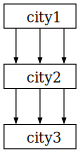

In [6]:
ncities = 3
roads = [1 => 2, 2=>3]
city_pattern = get_city_pattern(ncities, roads)

to_graphviz(city_pattern)

# Define a semantics for composition 

In [7]:
β(i) = Symbol("β$i"); γ(i) = Symbol("γ$i")

nout_roads = map(i -> count(r -> r.first == i, roads), 1:ncities)

sir_city_models = map(1:ncities) do i
    
    ContinuousMachine{Float64}(
        3,  # inputs
        3,  # states
        3,  # outputs
        (u,x,p,t) -> p.μ*(x - nout_roads[i]*u) + # flow in/out
            [ -p[β(i)]*u[1]*u[2],                # Ṡ
            p[β(i)]*u[1]*u[2] - p[γ(i)]*u[2],    # İ
            p[γ(i)]*u[2]],                       # Ṙ
        (u, p, t) -> u
    )
    
end;

## Compose!

In [8]:
sir_model = oapply(city_pattern, sir_city_models)

ContinuousMachine(ℝ^9 × ℝ^0 → ℝ^9)

In [9]:
params = LVector(μ = 0.01,
    β1 = 0.7, γ1 = 0.4,
    β2 = 0.4, γ2 = 0.4,
    β3 = 0.2, γ3 = 0.4
)

u0 = [100.0, 1.0, 0.0, 
      100.0, 0.0, 0.0, 
      100.0, 0.0, 0.0]  # initial populations

tspan = (0.0, 3.0)

prob = ODEProblem(sir_model, u0, tspan, params)
sol = solve(prob, Tsit5(); dtmax = 0.001)

plot(sol, vars = [1,2,3], lw = 2,
    label = ["city 1 - susceptible" "city 1 - infected" "city 1 - recovered"], 
    color = [:blue :darkblue :lightblue],
    foreground_color_legend = nothing,
    fontfamily = "Open Sans",
    ylabel = "population size",
    yguidefontsize= 12, xguidefontsize = 12
)

plot!(sol, vars = [4,5,6], lw = 2, 
        color = [:hotpink :deeppink :pink], 
        label = ["city 2 - susceptible" "city 2 - infected" "city 2 - recovered"]
)

plot!(sol, vars = [7,8,9], lw = 2, 
        color = [:limegreen :green :palegreen], 
        label = ["city 3 - susceptible" "city 3 - infected" "city 3 - recovered"], 
        xlabel = "time")

UndefVarError: UndefVarError: `LVector` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

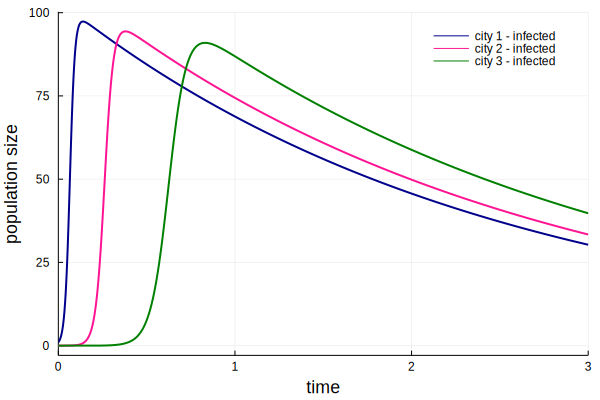

In [10]:
plot(sol, vars = [2], lw = 2,
    label = "city 1 - infected", 
    color =  :darkblue,
    foreground_color_legend = nothing,
    fontfamily = "Open Sans",
    ylabel = "population size",
    yguidefontsize= 12, xguidefontsize = 12
)

plot!(sol, vars = [5], lw = 2, 
        color = :deeppink, 
        label = "city 2 - infected"
)

plot!(sol, vars = [8], lw = 2, 
        color = :green, 
        label = "city 3 - infected", 
        xlabel = "time")

## Change to an SIR-Q Model

In [14]:
sirq_city_models = map(1:ncities) do i
    
    ContinuousMachine{Float64}(
        3,   # inputs
        5,   # states
        3,   # outputs
        (u,x,p,t) -> begin 
            q_rate =  0.75 #3.0*((u[2] + u[4])/sum(u))
            return p.μ*([x..., 0,0] - nout_roads[i]*u) + [
                -p[β(i)]*u[1]*u[2] - q_rate*u[1] + (1 - q_rate)*u[4],                # Ṡ
                p[β(i)]*u[1]*u[2] - p[γ(i)]*u[2] - q_rate*u[2] + (1 - q_rate)*u[5],  # İ
                p[γ(i)]*(u[2] + u[5]),                                               # Ṙ
                q_rate * u[1] - (1 - q_rate) * u[4],                                 # Q̇ₛ         
                q_rate * u[2] - (1 - q_rate) * u[5] - p[γ(i)]*u[5]]                  # Q̇ᵢ
        end,
        (u,p,t) -> u[1:3]
    )
    
end

sirq_model = oapply(city_pattern, sirq_city_models)

ContinuousMachine(ℝ^15 × ℝ^0 → ℝ^15)

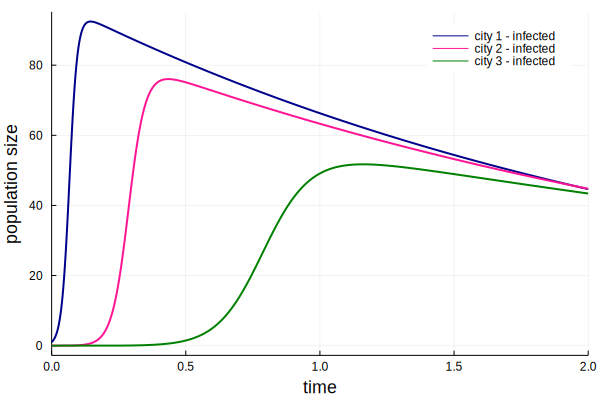

In [15]:
params = LVector(μ = 0.01,
    β1 = 0.7, γ1 = 0.4,
    β2 = 0.4, γ2 = 0.4,
    β3 = 0.2, γ3 = 0.4
)

u0 = [100.0, 1.0, 0.0, 0.0, 0.0, 
      100.0, 0.0, 0.0, 0.0, 0.0, 
      100.0, 0.0, 0.0, 0.0, 0.0]  # initial populations

tspan = (0.0, 2.0)

prob = ODEProblem(sirq_model, u0, tspan, params)
sol = solve(prob, Tsit5(); dtmax = 0.001)

s(t, x, y) = (t, x + y)


plot(sol, vars = [(s,0,2,5)], lw = 2,
    label = "city 1 - infected", 
    color =  :darkblue,
    foreground_color_legend = nothing,
    fontfamily = "Open Sans",
    ylabel = "population size",
    yguidefontsize= 12, xguidefontsize = 12
)

plot!(sol, vars = [(s,0,7,10)], lw = 2, 
        color = :deeppink, 
        label = "city 2 - infected"
)

plot!(sol, vars = [(s,0,12,15)], lw = 2, 
        color = :green, 
        label = "city 3 - infected", 
        xlabel = "time")

In [16]:
plot(sol, vars = [(s,0,1,4), (s,0,2,5) , ((t,x,y) -> (t,x), 0,3,3)], lw = 2,
    label = ["city 1 - susceptible" "city 1 - infected" "city 1 - recovered"], 
    color = [:blue :darkblue :lightblue],
    foreground_color_legend = nothing,
    fontfamily = "Open Sans",
    ylabel = "population size",
    yguidefontsize= 12, xguidefontsize = 12
)

plot!(sol, vars = [(s,0,6,9), (s,0,7,10) , ((t,x,y) -> (t,x), 0,8,8)], lw = 2, 
        color = [:hotpink :deeppink :pink], 
        label = ["city 2 - susceptible" "city 2 - infected" "city 2 - recovered"]
)

plot!(sol, vars = [(s,0,11,14), (s,0,12,15) , ((t,x,y) -> (t,x), 0,13,13)], lw = 2, 
        color = [:limegreen :green :palegreen], 
        label = ["city 3 - susceptible" "city 3 - infected" "city 3 - recovered"], 
        xlabel = "time")